In [111]:
#importing dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
from sklearn.metrics import roc_curve, auc

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel

# **Loading Dataset**

In [112]:
application_train = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
bureau = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau.csv')
bureau_balance = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau_balance.csv')
previous_application = pd.read_csv('/kaggle/input/home-credit-default-risk/previous_application.csv')
POS_CASH_balance = pd.read_csv('/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv')
credit_card_balance = pd.read_csv('/kaggle/input/home-credit-default-risk/credit_card_balance.csv')
installments_payments = pd.read_csv('/kaggle/input/home-credit-default-risk/installments_payments.csv')

In [114]:
#statistical information
application_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [115]:
#shape of training Data
application_train.shape

(307511, 122)

In [117]:
#counting the target variables
application_train["TARGET"].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

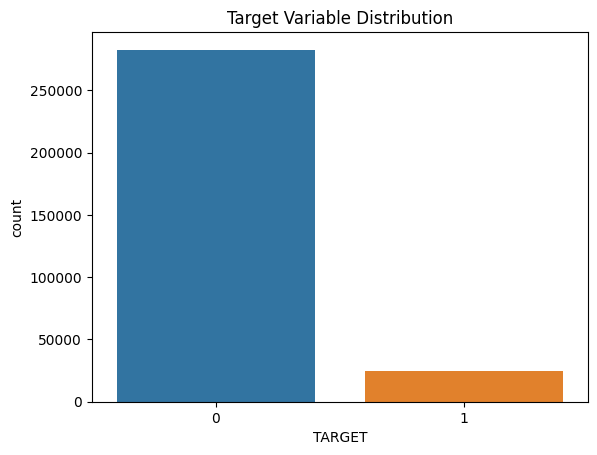

In [118]:
#plot for target variables
sns.countplot(x='TARGET', data=application_train)
plt.title("Target Variable Distribution")
plt.show()

# **Merging Tables**

In [119]:
#first five rows of bureau_balance
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [120]:
# Aggregate bureau_balance
bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg({
    'MONTHS_BALANCE': ['min', 'max', 'mean'],
    'STATUS': 'count'
}).reset_index()

# Flatten the column names for bureau_balance_agg
bureau_balance_agg.columns = ['_'.join(col) if col[1] else col[0] for col in bureau_balance_agg.columns]


In [121]:
#first 5 rows of bureau_balance_agg
bureau_balance_agg.head()

,SK_ID_BUREAU,MONTHS_BALANCE_min,MONTHS_BALANCE_max,MONTHS_BALANCE_mean,STATUS_count
0,5001709,-96,0,-48.0,97
1,5001710,-82,0,-41.0,83
2,5001711,-3,0,-1.5,4
3,5001712,-18,0,-9.0,19
4,5001713,-21,0,-10.5,22


In [122]:
# Merge aggregated bureau_balance with bureau
bureau_combined = bureau.merge(bureau_balance_agg, on='SK_ID_BUREAU', how='left')


In [123]:
#first five rows of bureau_combined
bureau_combined.head(10)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE_min,MONTHS_BALANCE_max,MONTHS_BALANCE_mean,STATUS_count
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,...,0.00,NaN,0.0,Consumer credit,-131,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,...,171342.00,NaN,0.0,Credit card,-20,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,...,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,...,NaN,NaN,0.0,Credit card,-16,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,...,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN,NaN,NaN,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,...,71017.38,108982.62,0.0,Credit card,-31,NaN,NaN,NaN,NaN,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,...,42103.80,0.00,0.0,Consumer credit,-22,NaN,NaN,NaN,NaN,NaN
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.0,0,...,0.00,0.00,0.0,Consumer credit,-1710,NaN,NaN,NaN,NaN,NaN
8,162297,5714470,Closed,currency 1,-1146,0,-811.0,-840.0,0.0,0,...,0.00,0.00,0.0,Consumer credit,-840,NaN,NaN,NaN,NaN,NaN
9,162297,5714471,Active,currency 1,-1146,0,-484.0,NaN,0.0,0,...,0.00,0.00,0.0,Credit card,-690,NaN,NaN,NaN,NaN,NaN


In [124]:
# Aggregate bureau_combined by SK_ID_CURR
bureau_agg = bureau_combined.groupby('SK_ID_CURR').agg({
    'CREDIT_ACTIVE': 'count',                    # Count of active credits
    'DAYS_CREDIT': ['mean', 'min'],              # Mean and min of credit days
    'AMT_CREDIT_SUM': ['sum', 'mean'],           # Total and average credit sum
    'AMT_CREDIT_SUM_OVERDUE': 'sum'              # Total overdue credit
}).reset_index()

# Flatten the column names for bureau_agg
bureau_agg.columns = ['_'.join(col) if col[1] else col[0] for col in bureau_agg.columns]


In [125]:
#first five rows of bureau_agg
bureau_agg.head(10)

,SK_ID_CURR,CREDIT_ACTIVE_count,DAYS_CREDIT_mean,DAYS_CREDIT_min,AMT_CREDIT_SUM_sum,AMT_CREDIT_SUM_mean,AMT_CREDIT_SUM_OVERDUE_sum
0,100001,7,-735.000000,-1572,1453365.000,207623.571429,0.0
1,100002,8,-874.000000,-1437,865055.565,108131.945625,0.0
2,100003,4,-1400.750000,-2586,1017400.500,254350.125000,0.0
3,100004,2,-867.000000,-1326,189037.800,94518.900000,0.0
4,100005,3,-190.666667,-373,657126.000,219042.000000,0.0
5,100007,1,-1149.000000,-1149,146250.000,146250.000000,0.0
6,100008,3,-757.333333,-1097,468445.500,156148.500000,0.0
7,100009,18,-1271.500000,-2882,4800811.500,266711.750000,0.0
8,100010,2,-1939.500000,-2741,990000.000,495000.000000,0.0
9,100011,4,-1773.000000,-2508,435228.300,108807.075000,0.0


In [126]:
# Aggregate bureau data by SK_ID_CURR
bureau_agg = bureau_combined.groupby('SK_ID_CURR').agg({
    'CREDIT_ACTIVE': 'count',
    'DAYS_CREDIT': ['mean', 'min'],
    'AMT_CREDIT_SUM': ['sum', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': 'sum'
}).reset_index()
bureau_agg.columns = ['_'.join(col) if col[1] else col[0] for col in bureau_agg.columns]

In [127]:
#first five rows of previous_application
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
# Aggregate previous_application
previous_application_agg = previous_application.groupby('SK_ID_CURR').agg({
    'AMT_APPLICATION': ['mean', 'min', 'max'],
    'AMT_CREDIT': ['mean', 'sum'],
    'NAME_CONTRACT_STATUS': 'count'
}).reset_index()
previous_application_agg.columns = ['_'.join(col) if col[1] else col[0] for col in previous_application_agg.columns]


In [129]:
# first five rows of previous_application_agg
previous_application_agg.head()

,SK_ID_CURR,AMT_APPLICATION_mean,AMT_APPLICATION_min,AMT_APPLICATION_max,AMT_CREDIT_mean,AMT_CREDIT_sum,NAME_CONTRACT_STATUS_count
0,100001,24835.50,24835.5,24835.5,23787.00,23787.0,1
1,100002,179055.00,179055.0,179055.0,179055.00,179055.0,1
2,100003,435436.50,68809.5,900000.0,484191.00,1452573.0,3
3,100004,24282.00,24282.0,24282.0,20106.00,20106.0,1
4,100005,22308.75,0.0,44617.5,20076.75,40153.5,2


In [130]:
# first five rows of POS_CASH_balance
POS_CASH_balance.head(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
5,2207092,342166,-32,12.0,12.0,Active,0,0
6,1110516,204376,-38,48.0,43.0,Active,0,0
7,1387235,153211,-35,36.0,36.0,Active,0,0
8,1220500,112740,-31,12.0,12.0,Active,0,0
9,2371489,274851,-32,24.0,16.0,Active,0,0


In [131]:
# Aggregate POS_CASH_balance
POS_CASH_agg = POS_CASH_balance.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': ['mean', 'min', 'max'],
    'CNT_INSTALMENT': ['mean', 'sum']
}).reset_index()
POS_CASH_agg.columns = ['_'.join(col) if col[1] else col[0] for col in POS_CASH_agg.columns]


In [132]:
#first five rows of POS_CASH_agg
POS_CASH_agg.head()

,SK_ID_CURR,MONTHS_BALANCE_mean,MONTHS_BALANCE_min,MONTHS_BALANCE_max,CNT_INSTALMENT_mean,CNT_INSTALMENT_sum
0,100001,-72.555556,-96,-53,4.000000,36.0
1,100002,-10.000000,-19,-1,24.000000,456.0
2,100003,-43.785714,-77,-18,10.107143,283.0
3,100004,-25.500000,-27,-24,3.750000,15.0
4,100005,-20.000000,-25,-15,11.700000,117.0


In [133]:
# first five rows of credit_card_balance
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [134]:
# Aggregate credit_card_balance
credit_card_agg = credit_card_balance.groupby('SK_ID_CURR').agg({
    'AMT_BALANCE': ['mean', 'sum'],
    'AMT_CREDIT_LIMIT_ACTUAL': 'mean',
    'AMT_DRAWINGS_CURRENT': ['mean', 'sum']
}).reset_index()
credit_card_agg.columns = ['_'.join(col) if col[1] else col[0] for col in credit_card_agg.columns]


In [135]:
# first five rows of credit_card_agg
credit_card_agg.head()

,SK_ID_CURR,AMT_BALANCE_mean,AMT_BALANCE_sum,AMT_CREDIT_LIMIT_ACTUAL_mean,AMT_DRAWINGS_CURRENT_mean,AMT_DRAWINGS_CURRENT_sum
0,100006,0.000000,0.000,270000.000000,0.000000,0.0
1,100011,54482.111149,4031676.225,164189.189189,2432.432432,180000.0
2,100013,18159.919219,1743352.245,131718.750000,5953.125000,571500.0
3,100021,0.000000,0.000,675000.000000,0.000000,0.0
4,100023,0.000000,0.000,135000.000000,0.000000,0.0


In [136]:
# First five rows of installments_payments
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [137]:
# Aggregate installments_payments
installments_agg = installments_payments.groupby('SK_ID_CURR').agg({
    'AMT_PAYMENT': ['mean', 'sum', 'max'],
    'DAYS_INSTALMENT': ['mean', 'min'],
    'DAYS_ENTRY_PAYMENT': 'mean'
}).reset_index()
installments_agg.columns = ['_'.join(col) if col[1] else col[0] for col in installments_agg.columns]


In [138]:
# first five rows of installments_agg
installments_agg.head()

,SK_ID_CURR,AMT_PAYMENT_mean,AMT_PAYMENT_sum,AMT_PAYMENT_max,DAYS_INSTALMENT_mean,DAYS_INSTALMENT_min,DAYS_ENTRY_PAYMENT_mean
0,100001,5885.132143,41195.925,17397.900,-2187.714286,-2916.0,-2195.000000
1,100002,11559.247105,219625.695,53093.745,-295.000000,-565.0,-315.421053
2,100003,64754.586000,1618864.650,560835.360,-1378.160000,-2310.0,-1385.320000
3,100004,7096.155000,21288.465,10573.965,-754.000000,-784.0,-761.666667
4,100005,6240.205000,56161.845,17656.245,-586.000000,-706.0,-609.555556


In [139]:
# Merge all tables with the main application_train dataset
application_train_combined = application_train.merge(bureau_agg, on='SK_ID_CURR', how='left')
application_train_combined = application_train.merge(previous_application_agg, on='SK_ID_CURR', how='left')
application_train_combined = application_train_combined.merge(POS_CASH_agg, on='SK_ID_CURR', how='left')
application_train_combined = application_train_combined.merge(credit_card_agg, on='SK_ID_CURR', how='left')
application_train_combined = application_train_combined.merge(installments_agg, on='SK_ID_CURR', how='left')


# **Processing**

In [140]:
app_train = application_train_combined

In [141]:
#shape of final training data
app_train.shape

(307511, 144)

In [142]:
#first 10 rows
app_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_BALANCE_sum,AMT_CREDIT_LIMIT_ACTUAL_mean,AMT_DRAWINGS_CURRENT_mean,AMT_DRAWINGS_CURRENT_sum,AMT_PAYMENT_mean,AMT_PAYMENT_sum,AMT_PAYMENT_max,DAYS_INSTALMENT_mean,DAYS_INSTALMENT_min,DAYS_ENTRY_PAYMENT_mean
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,11559.247105,219625.695,53093.745,-295.000000,-565.0,-315.421053
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,64754.586000,1618864.650,560835.360,-1378.160000,-2310.0,-1385.320000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,7096.155000,21288.465,10573.965,-754.000000,-784.0,-761.666667
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.000,270000.000000,0.000000,0.0,62947.088438,1007153.415,691786.890,-252.250000,-545.0,-271.625000
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,12214.060227,806127.975,22678.785,-1028.606061,-2326.0,-1032.242424
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,NaN,NaN,NaN,NaN,27360.502714,957617.595,432218.295,-1263.914286,-2491.0,-1237.800000
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,NaN,NaN,NaN,NaN,9568.531765,487995.120,17341.605,-855.823529,-2908.0,-864.411765
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,NaN,NaN,NaN,NaN,27449.208000,274492.080,27463.410,-904.000000,-1039.0,-915.900000
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,4031676.225,164189.189189,2432.432432,180000.0,11328.893654,1472756.175,46485.000,-1154.061538,-2477.0,-1150.923077
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,NaN,NaN,NaN,NaN,10451.285625,501661.710,58687.245,-665.000000,-1641.0,-690.312500


In [143]:
app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,AMT_BALANCE_sum,AMT_CREDIT_LIMIT_ACTUAL_mean,AMT_DRAWINGS_CURRENT_mean,AMT_DRAWINGS_CURRENT_sum,AMT_PAYMENT_mean,AMT_PAYMENT_sum,AMT_PAYMENT_max,DAYS_INSTALMENT_mean,DAYS_INSTALMENT_min,DAYS_ENTRY_PAYMENT_mean
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,8.690500e+04,8.690500e+04,8.690500e+04,8.690500e+04,2.916350e+05,2.916430e+05,2.916350e+05,291643.000000,291643.000000,291635.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,2.194196e+06,2.082606e+05,1.391348e+04,2.783573e+05,1.875431e+04,6.785854e+05,1.381792e+05,-909.662335,-1584.949140,-920.961181
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,3.266996e+06,1.915299e+05,2.661058e+04,4.450129e+05,2.510536e+04,9.161681e+05,2.477880e+05,598.461681,913.707997,597.024650
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,-1.260000e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.890000e-01,0.000000e+00,2.250000e-01,-2922.000000,-2922.000000,-3071.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000e+00,8.284091e+04,0.000000e+00,0.000000e+00,7.478370e+03,1.308270e+05,1.409717e+04,-1301.959806,-2471.000000,-1311.842195
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,7.385753e+05,1.497273e+05,3.473672e+03,1.469785e+05,1.222576e+04,3.186195e+05,3.600000e+04,-795.953488,-1539.000000,-807.581818
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,3.075180e+06,2.687838e+05,1.833400e+04,3.673708e+05,2.135286e+04,8.330939e+05,1.329875e+05,-419.000000,-713.000000,-431.609963
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,2.998048e+07,1.350000e+06,1.125000e+06,1.846930e+07,2.504590e+06,2.553705e+07,3.771488e+06,-3.000000,-3.000000,-3.000000


In [144]:
#counting missing data in target
app_train["TARGET"].isnull().sum()

0

In [145]:
#couting values of target 
app_train["TARGET"].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

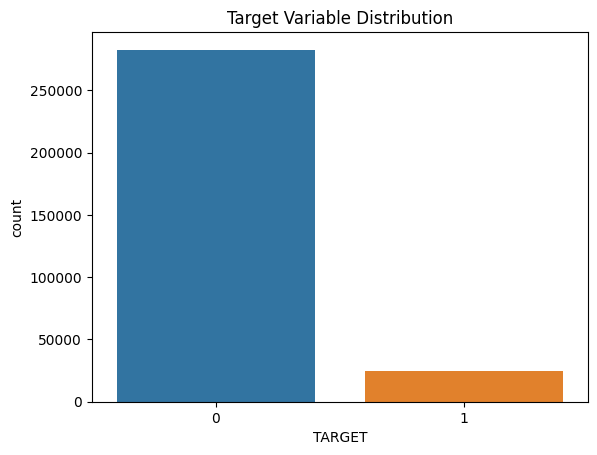

In [146]:
#plot of target
sns.countplot(x='TARGET', data=app_train)
plt.title("Target Variable Distribution")
plt.show()

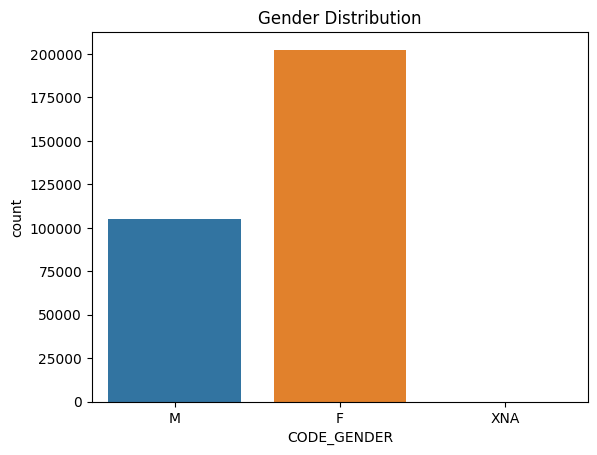

In [147]:
#plot of Gender Distribution
sns.countplot(x='CODE_GENDER', data=app_train)
plt.title("Gender Distribution")
plt.show()

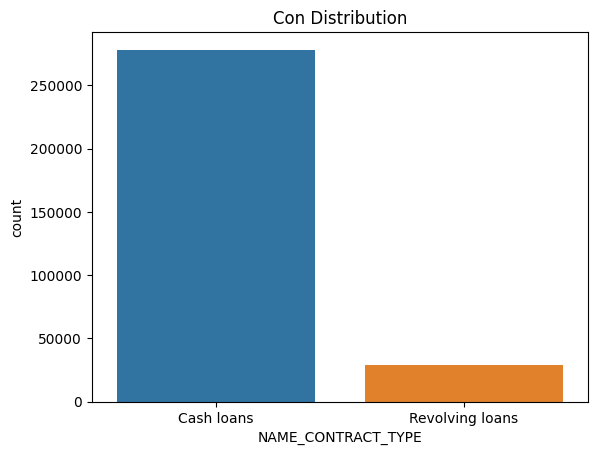

In [148]:
#plot of Contract type
sns.countplot(x='NAME_CONTRACT_TYPE', data=app_train)
plt.title("Con Distribution")
plt.show()

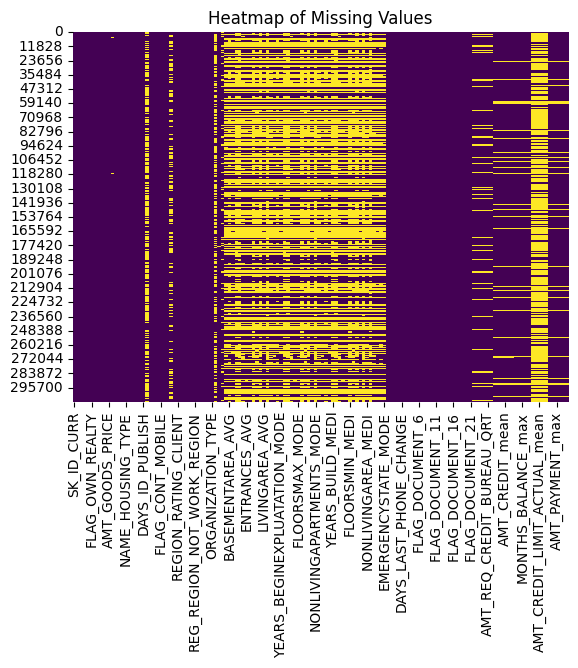

In [149]:
# Plot heatmap of missing values
sns.heatmap(app_train.isnull(), cbar=False, cmap='viridis')
plt.title("Heatmap of Missing Values")
plt.show()

In [150]:
#Count the columns which have missing values
train_missing_cols = app_train.columns[app_train.isnull().any()].tolist()
num_missing_cols = len(train_missing_cols)

In [151]:
#total missing columns
num_missing_cols

89

In [152]:
#new dataframe with missing values
null_columns_train = app_train[train_missing_cols]

null_columns_train.shape

(307511, 89)

In [153]:
#percentage of missing values for each column
missing_percentage = null_columns_train.isnull().sum() / len(null_columns_train) * 100

missing_percentage

AMT_ANNUITY                 0.003902
AMT_GOODS_PRICE             0.090403
NAME_TYPE_SUITE             0.420148
OWN_CAR_AGE                65.990810
OCCUPATION_TYPE            31.345545
                             ...    
AMT_PAYMENT_sum             5.160141
AMT_PAYMENT_max             5.162742
DAYS_INSTALMENT_mean        5.160141
DAYS_INSTALMENT_min         5.160141
DAYS_ENTRY_PAYMENT_mean     5.162742
Length: 89, dtype: float64

In [154]:
#Columns with missing percentage greater than 50%
coulumnss = missing_percentage[missing_percentage> 50]
print(len(coulumnss))

46


In [155]:
# Get the columns to drop
columns_to_drop = coulumnss.index.tolist()

# Drop the columns from app_train
app_train = app_train.drop(columns=columns_to_drop)

# shape of App_train after removing missing columns (greater than 50%) 
app_train.shape

(307511, 98)

In [156]:
num_imputer = SimpleImputer(strategy="mean")
cat_imputer = SimpleImputer(strategy="most_frequent")

# Identifying numerical columns
numerical_cols = app_train.select_dtypes(include=["float64", "int64"]).columns

#identifying Categorical columns
categorical_cols = app_train.select_dtypes(include=["object"]).columns

#replacing missing values with mean in numerical columns
app_train[numerical_cols] = num_imputer.fit_transform(app_train[numerical_cols])

#replacing missing values with mode in categorical columns
app_train[categorical_cols] = cat_imputer.fit_transform(app_train[categorical_cols])


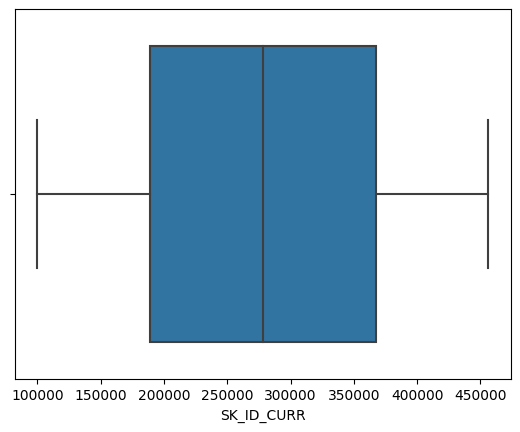

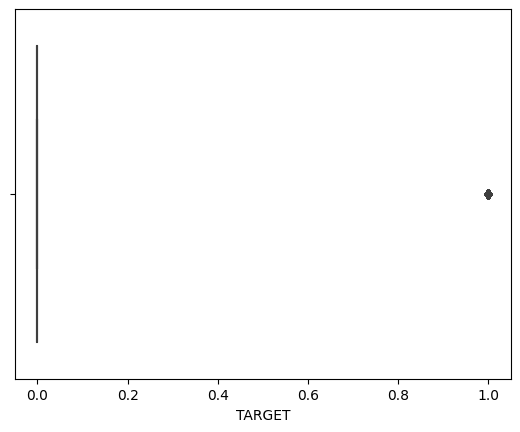

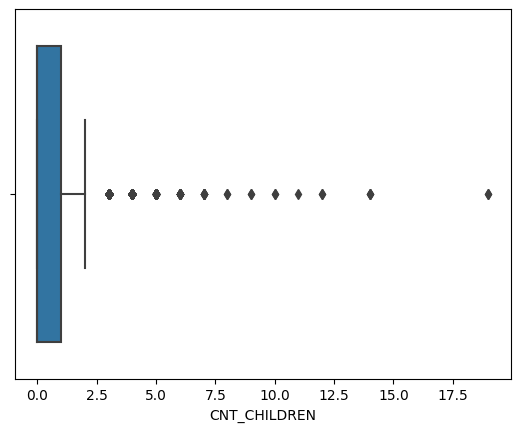

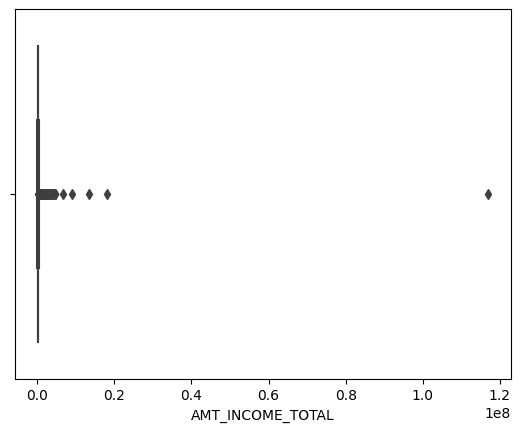

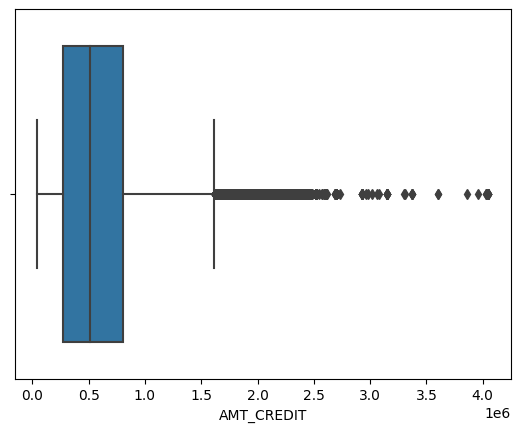

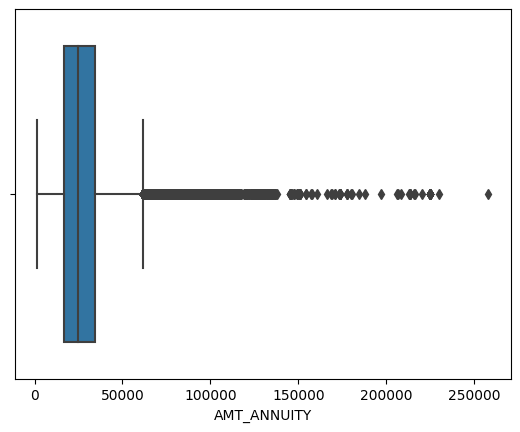

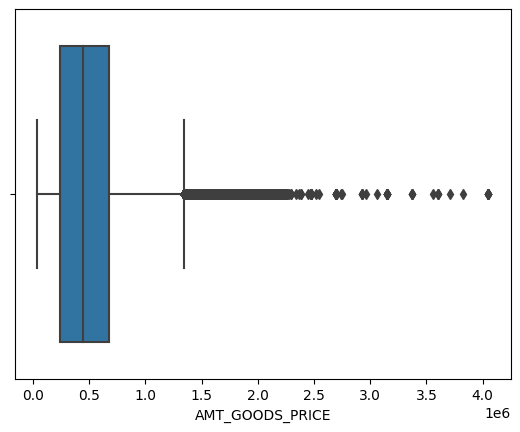

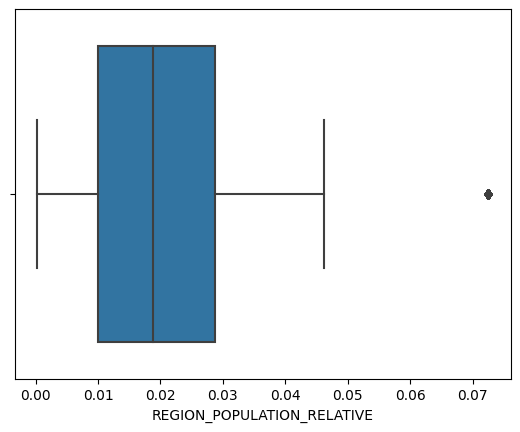

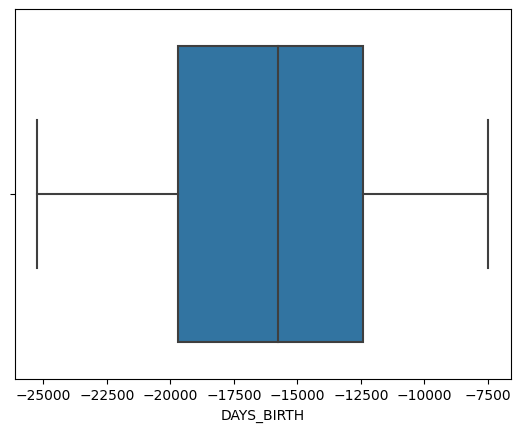

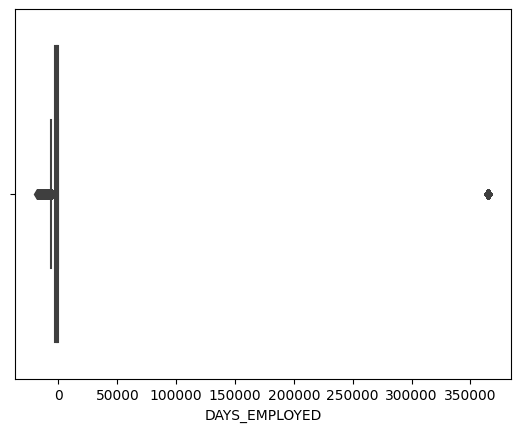

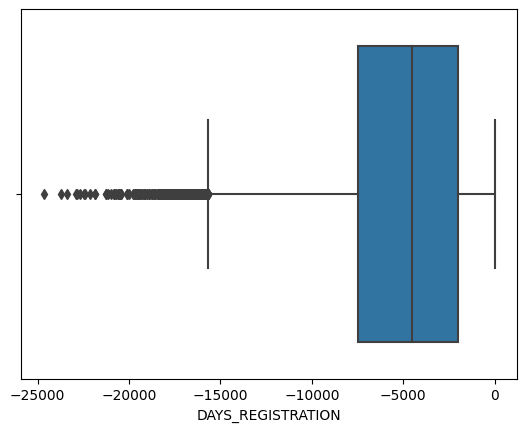

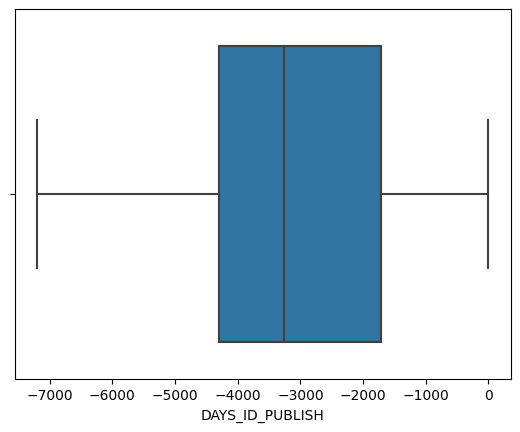

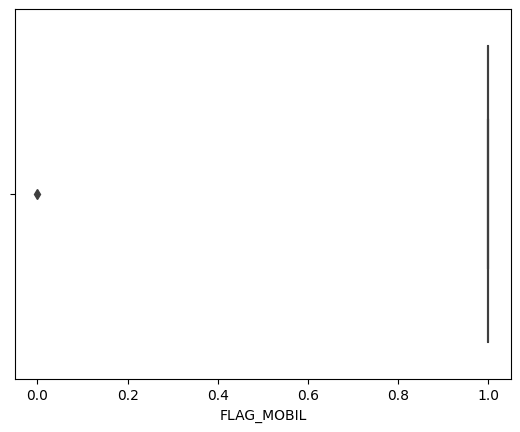

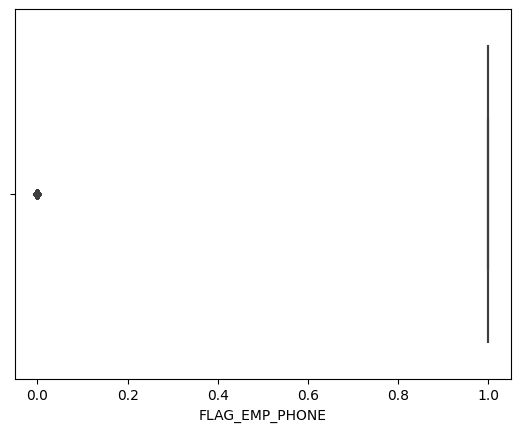

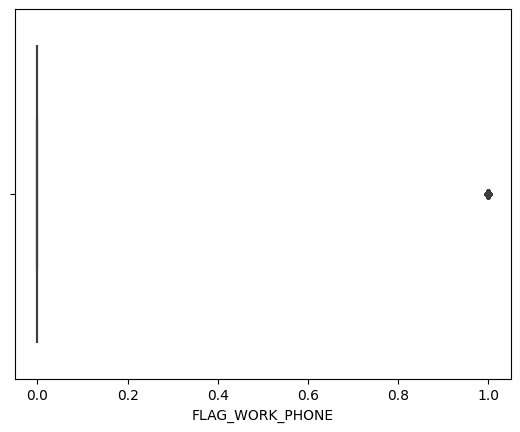

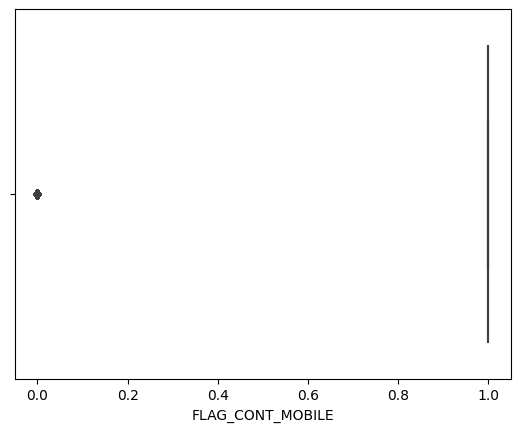

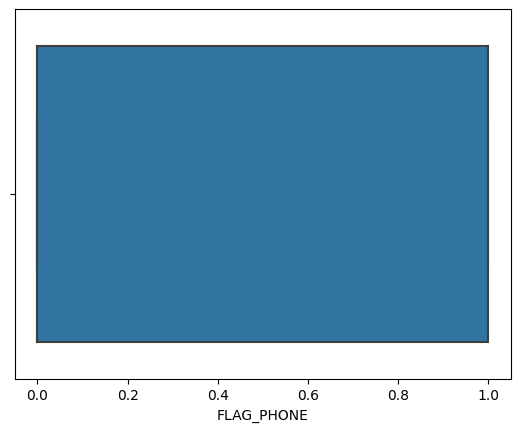

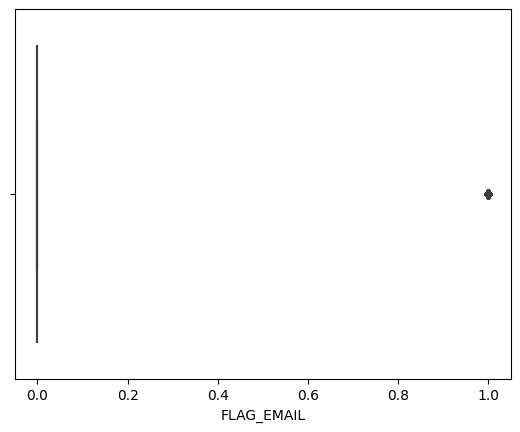

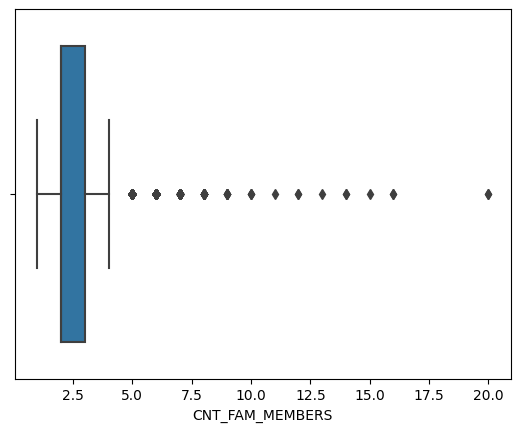

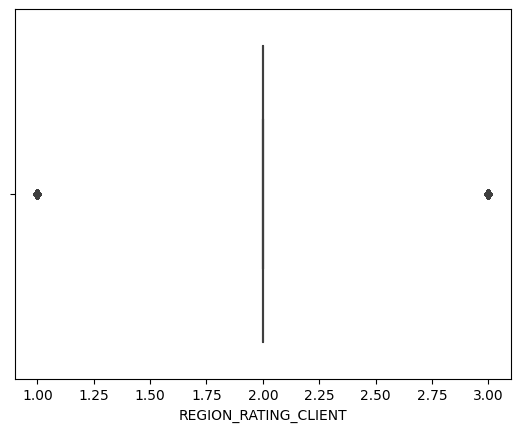

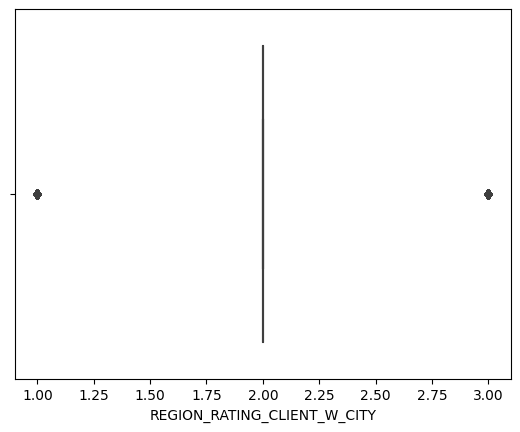

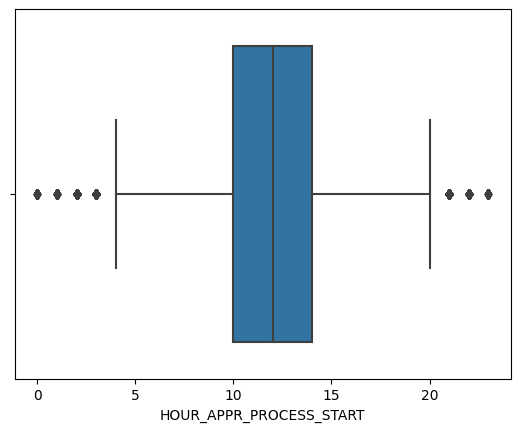

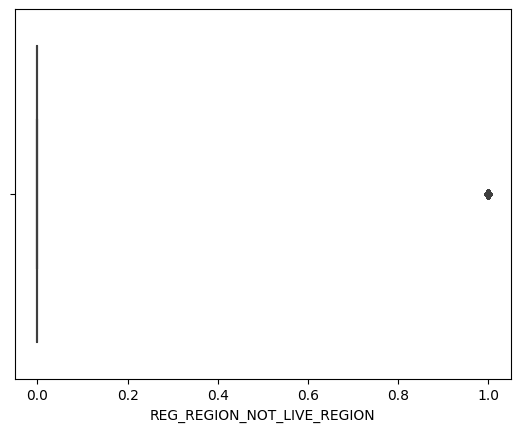

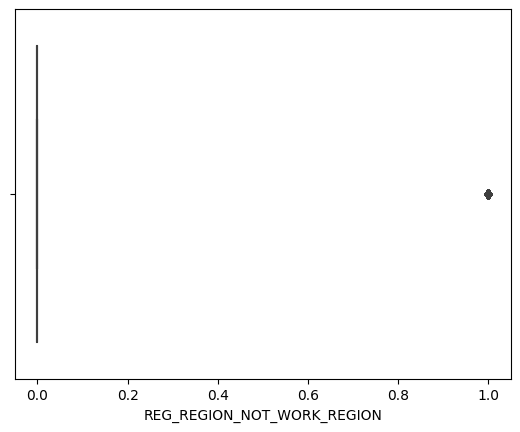

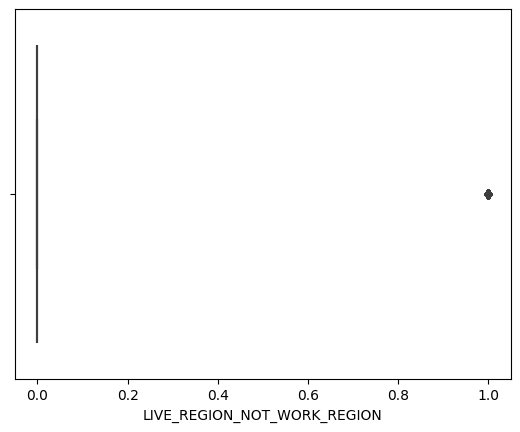

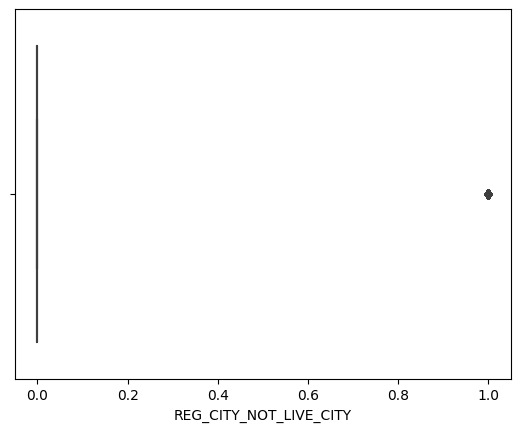

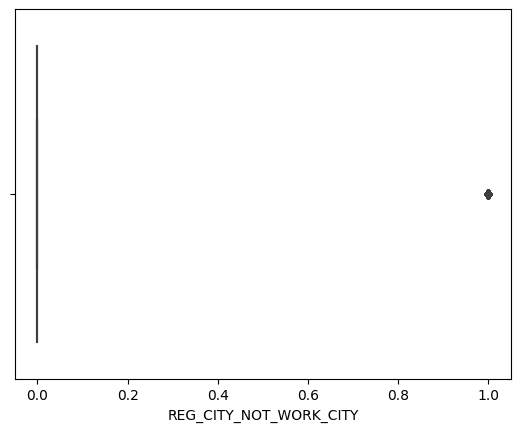

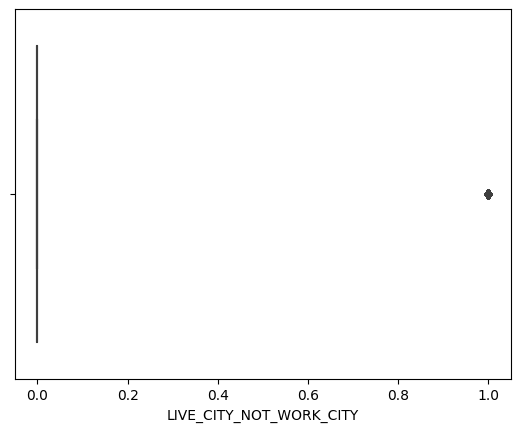

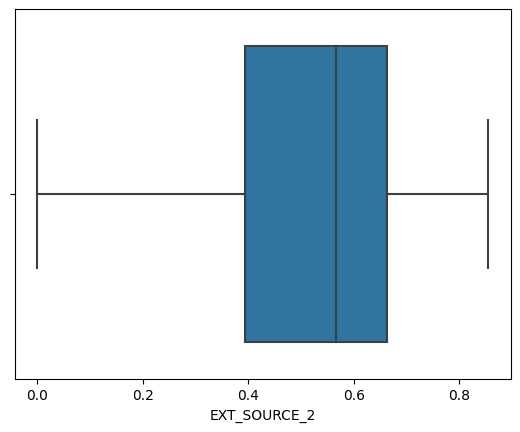

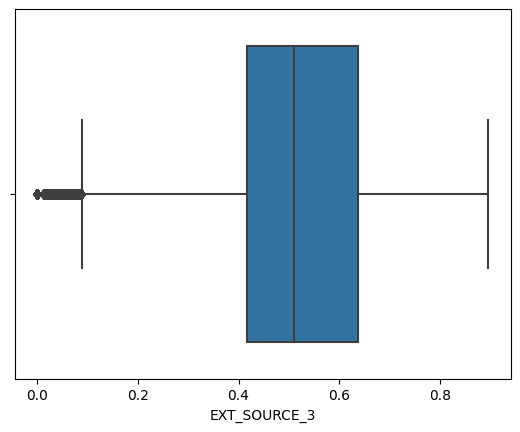

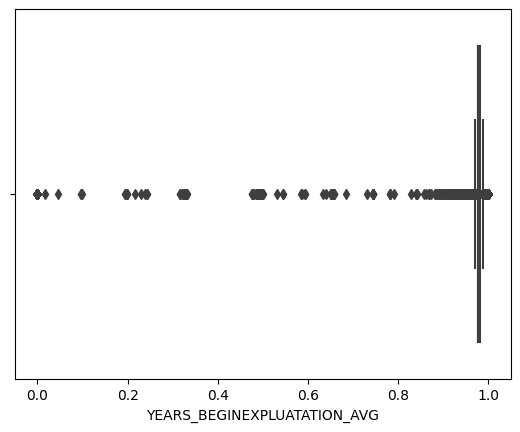

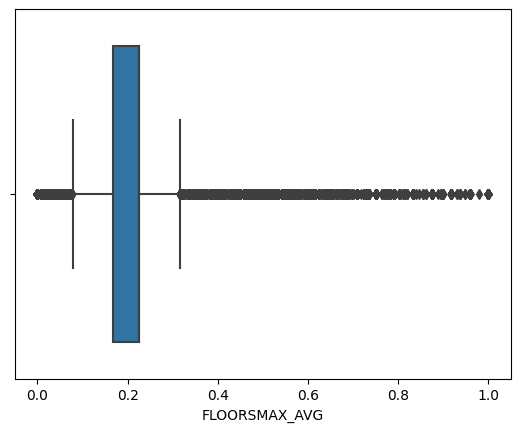

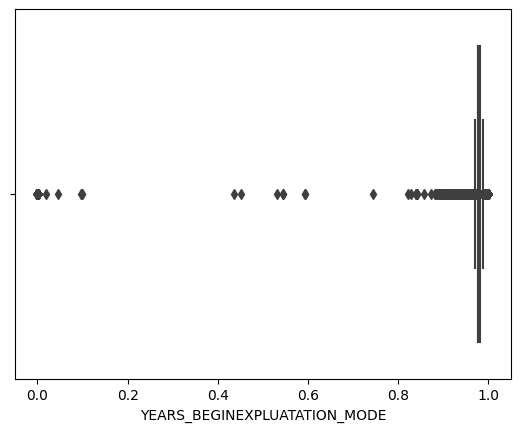

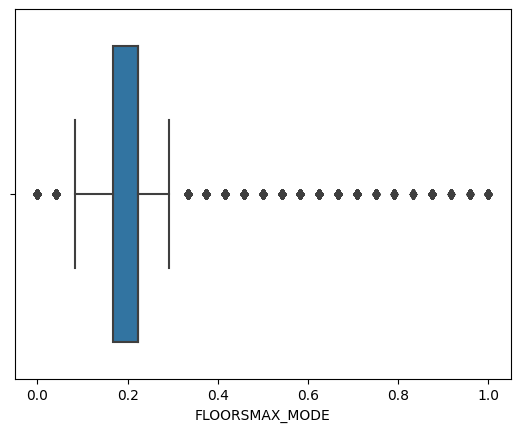

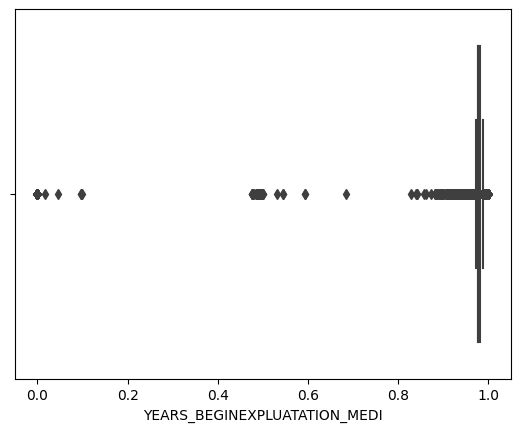

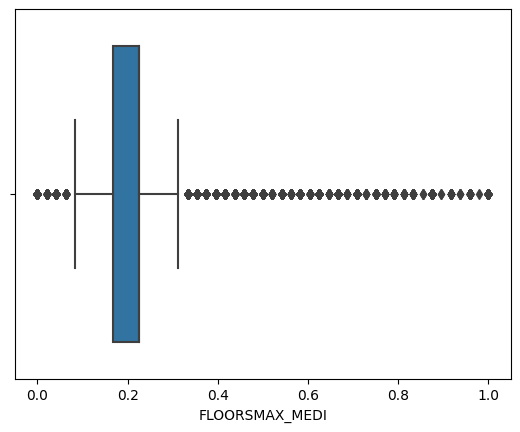

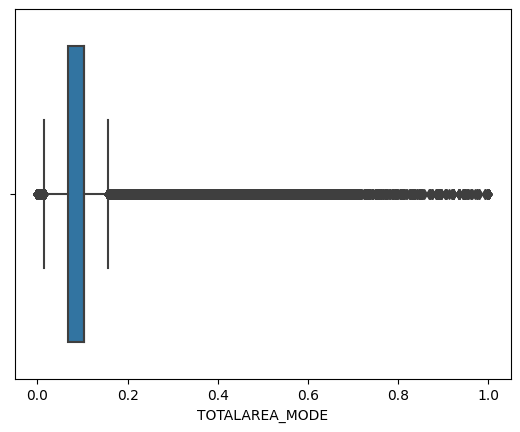

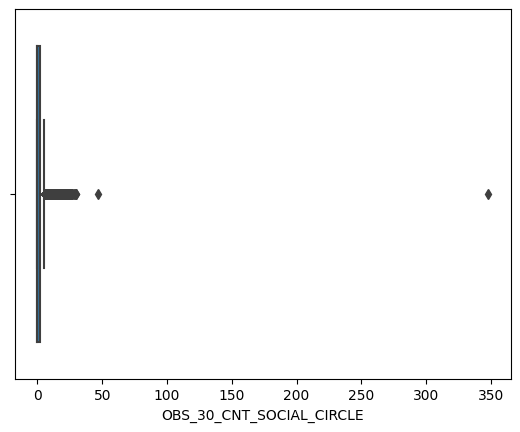

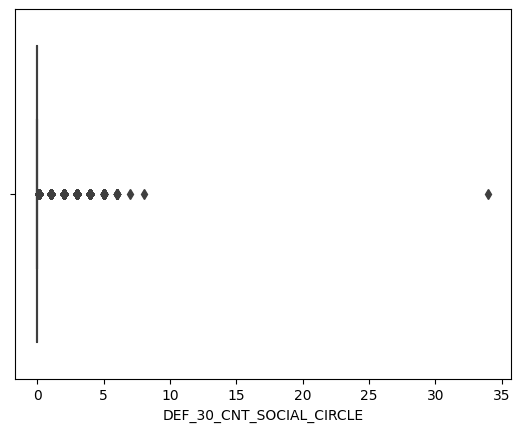

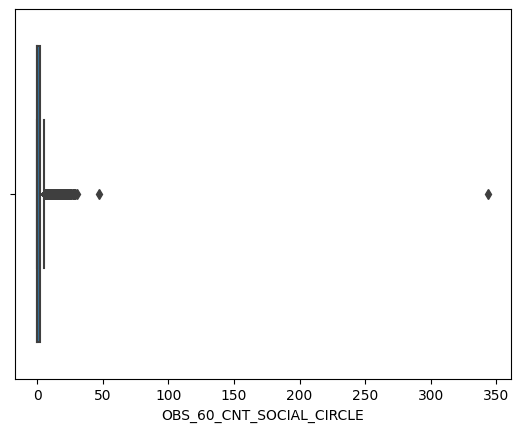

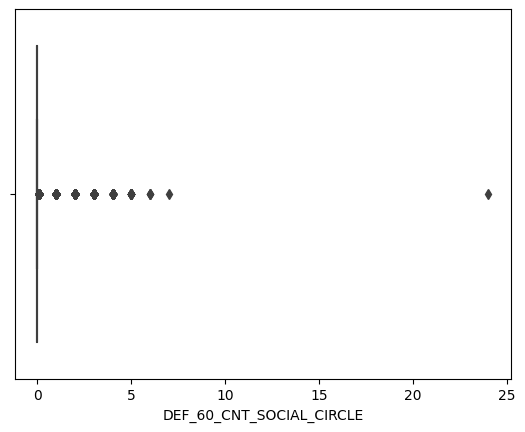

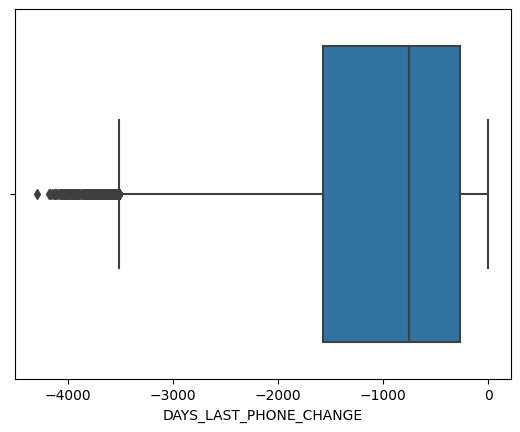

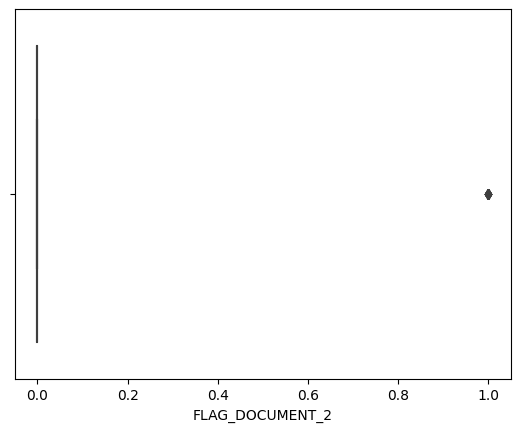

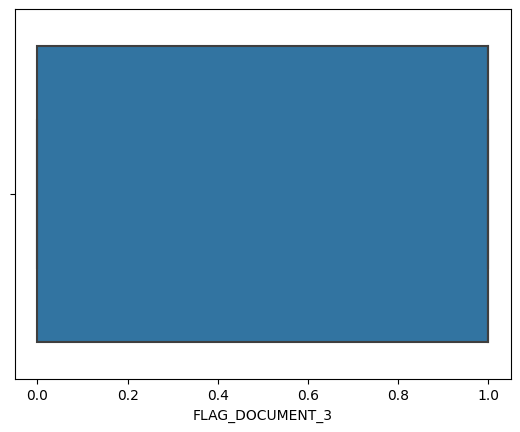

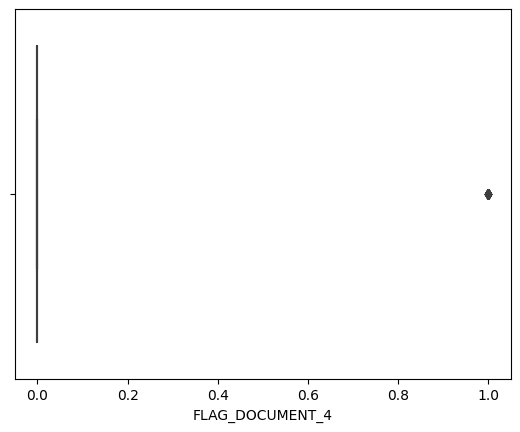

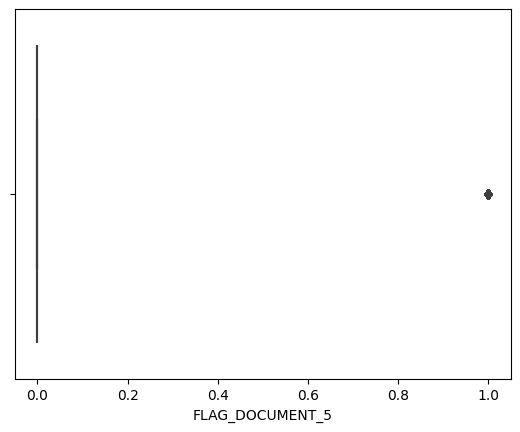

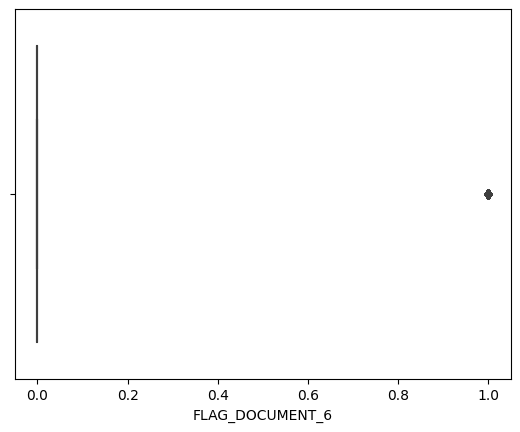

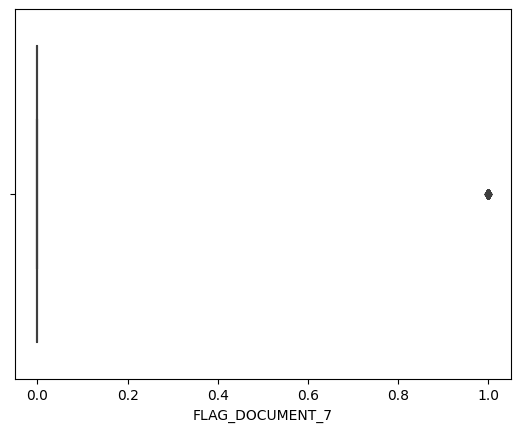

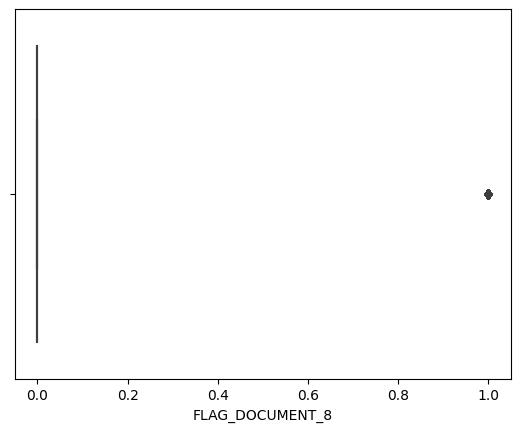

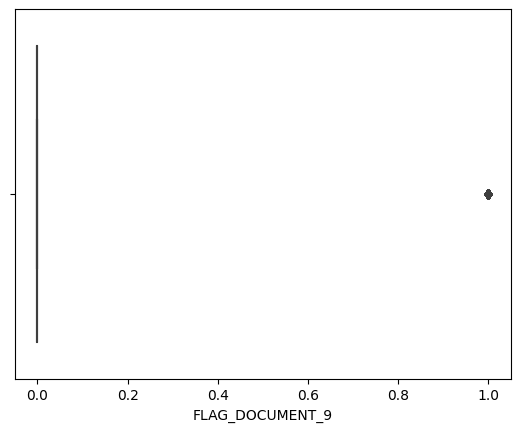

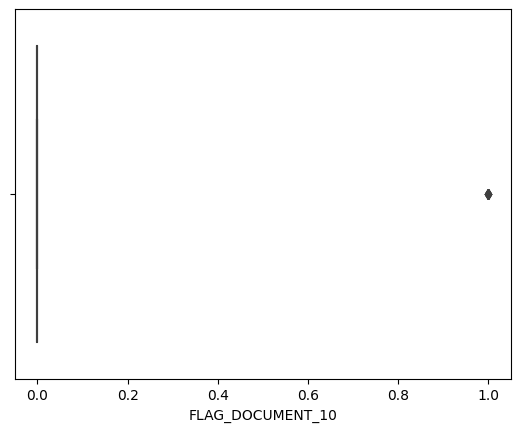

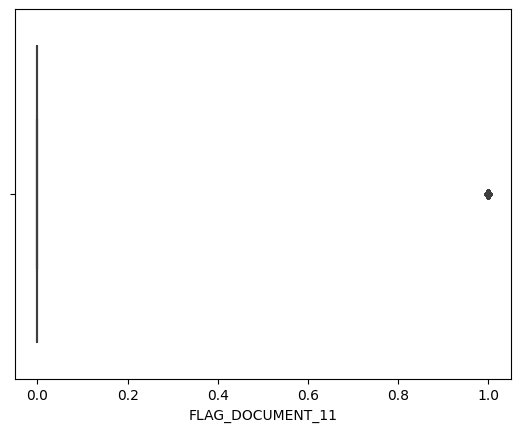

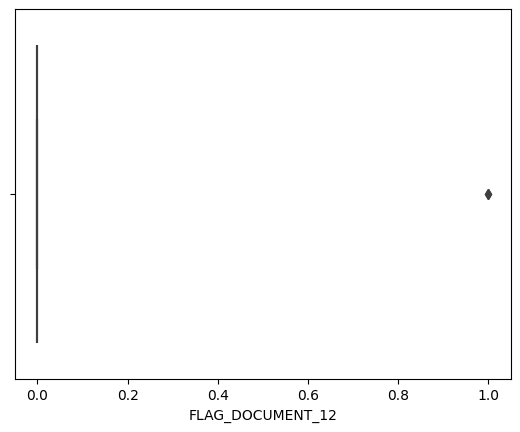

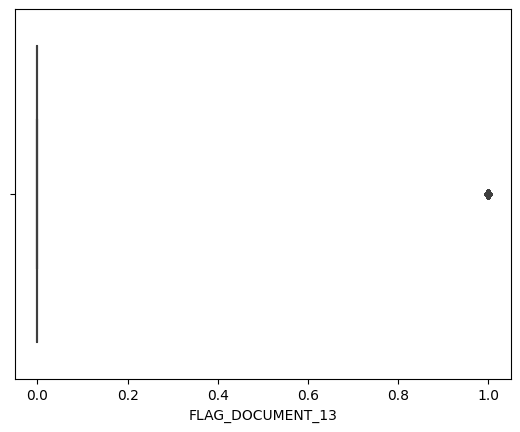

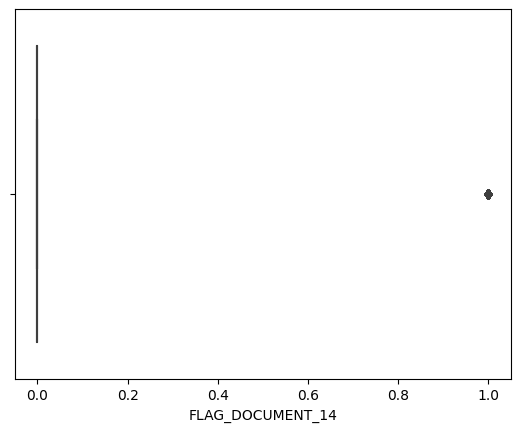

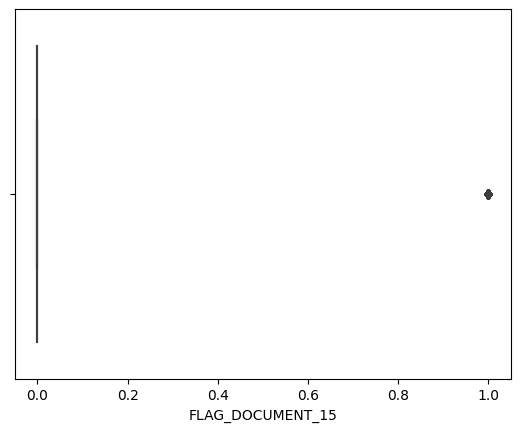

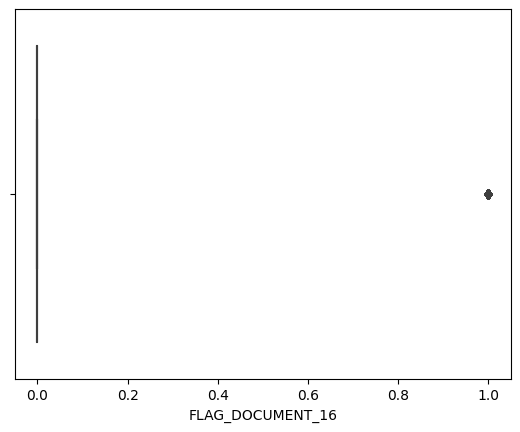

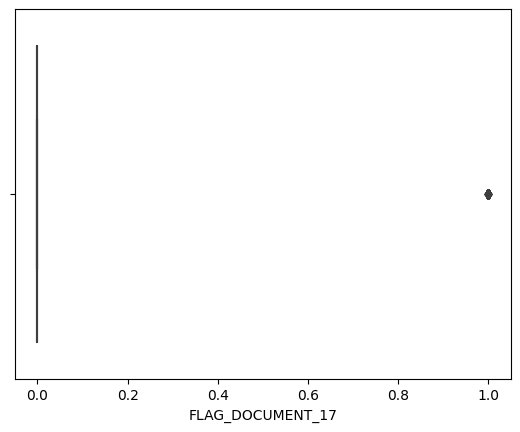

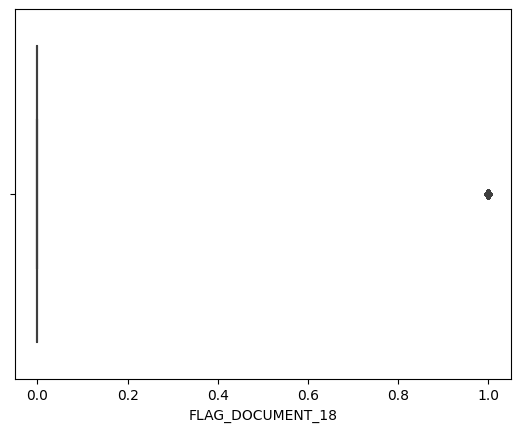

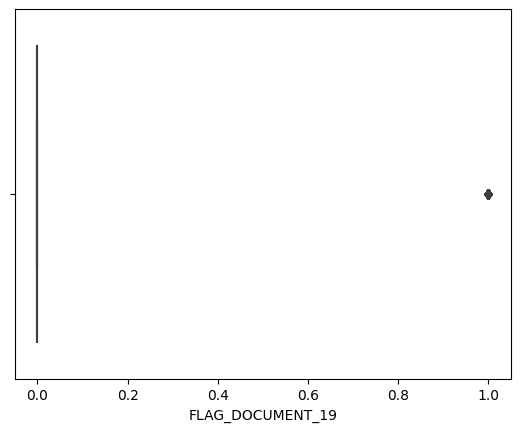

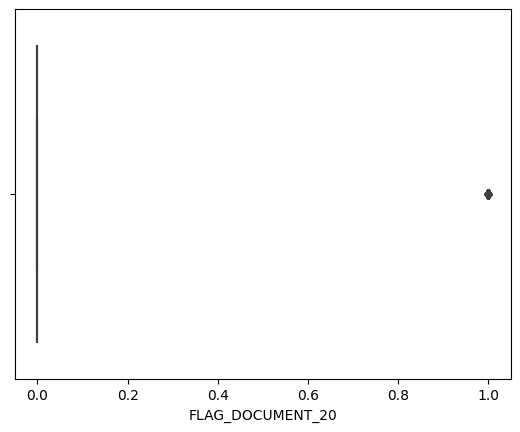

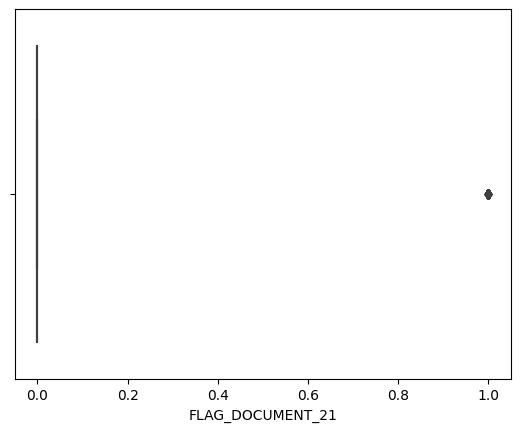

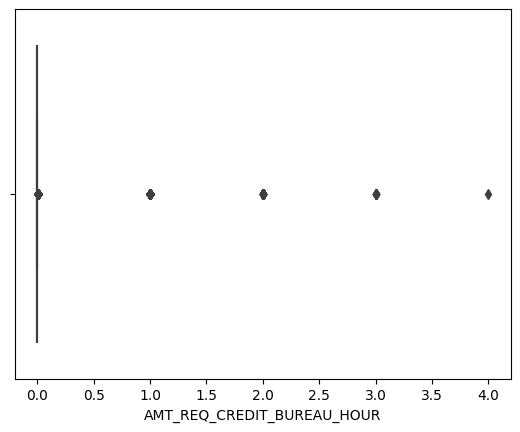

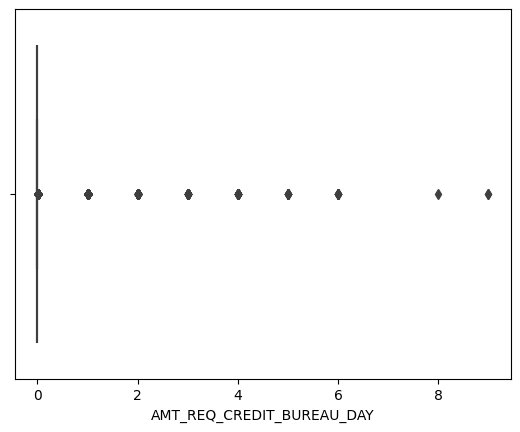

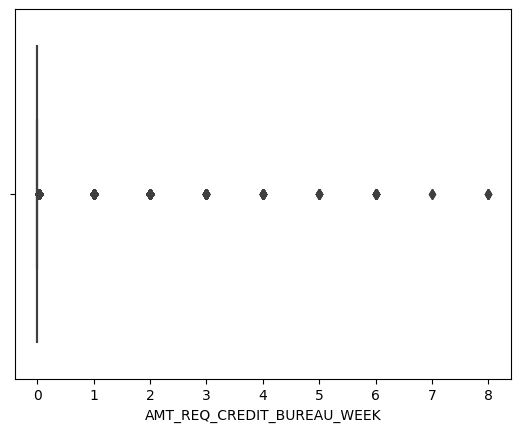

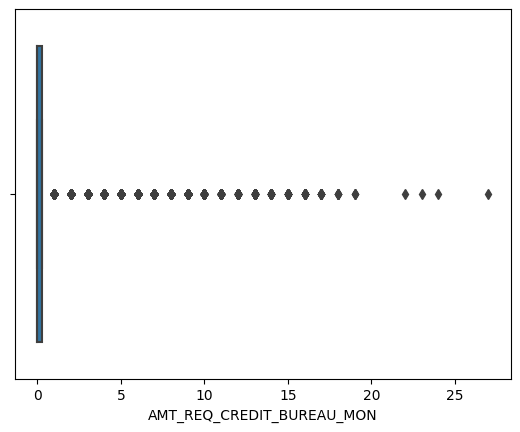

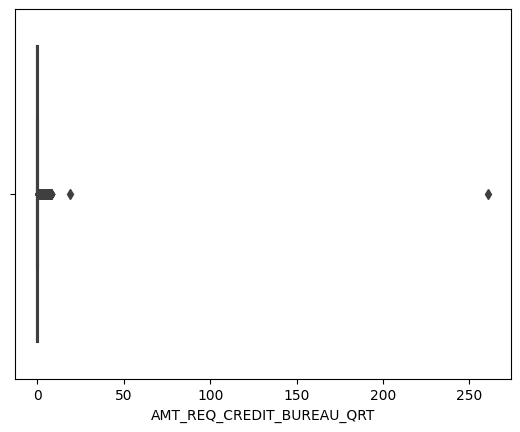

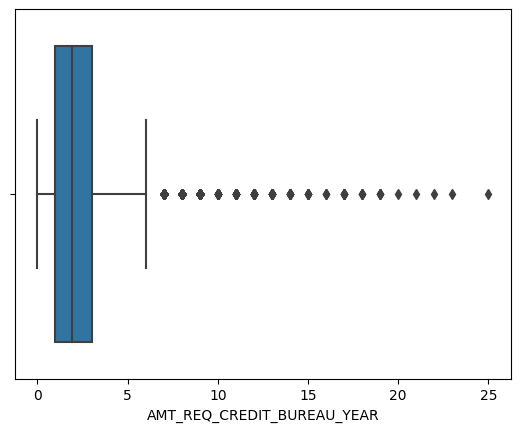

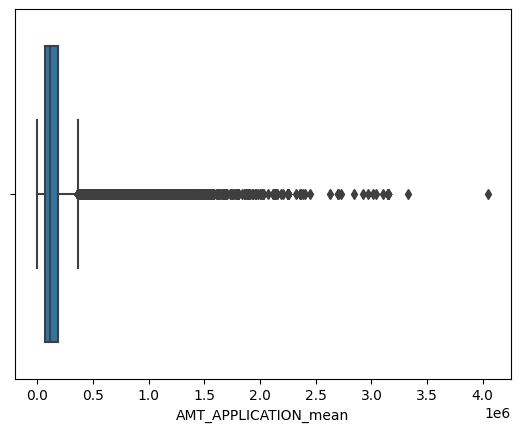

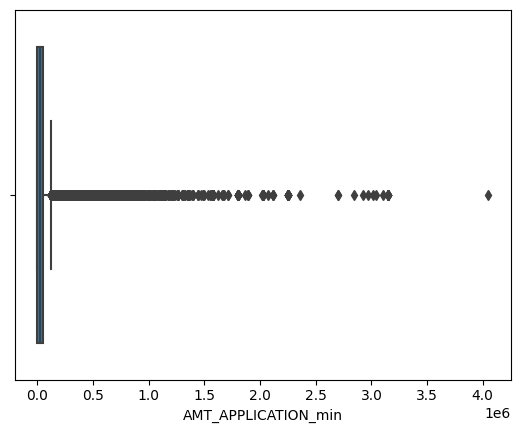

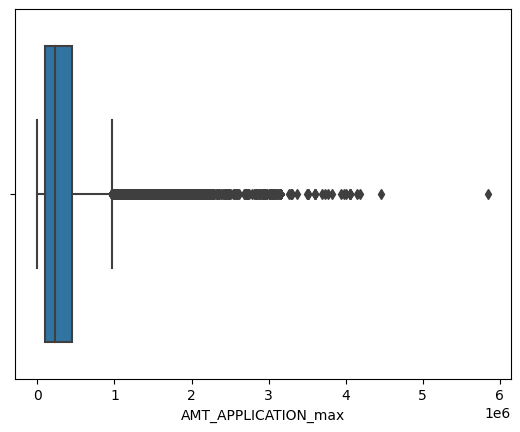

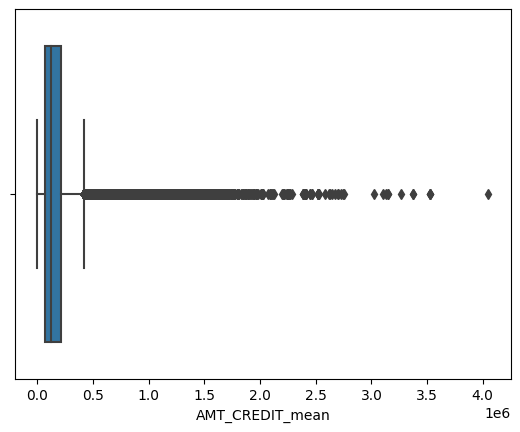

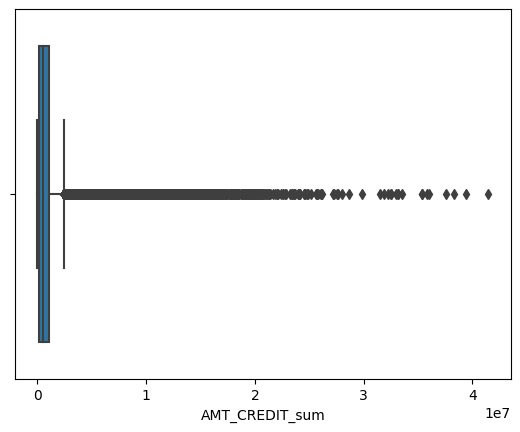

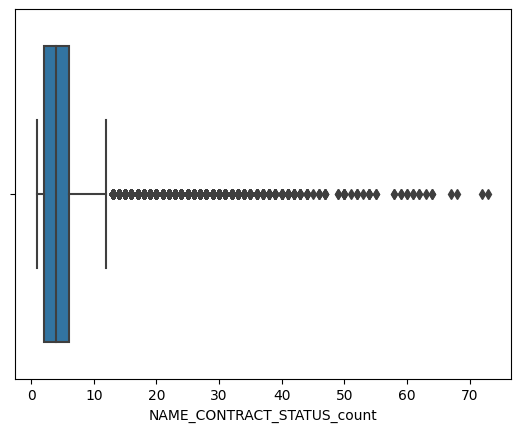

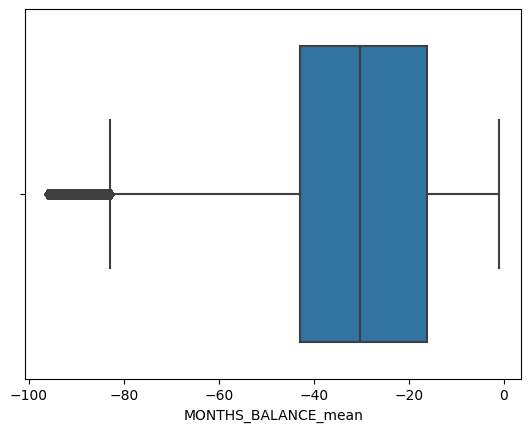

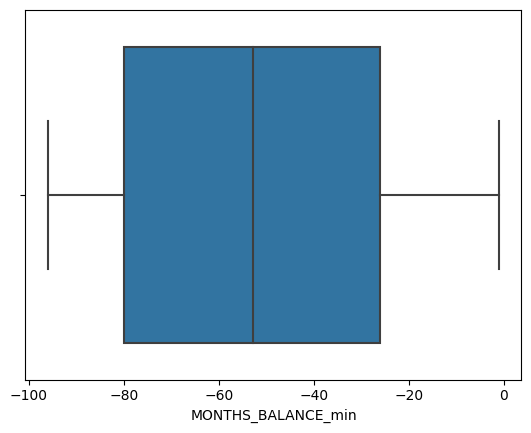

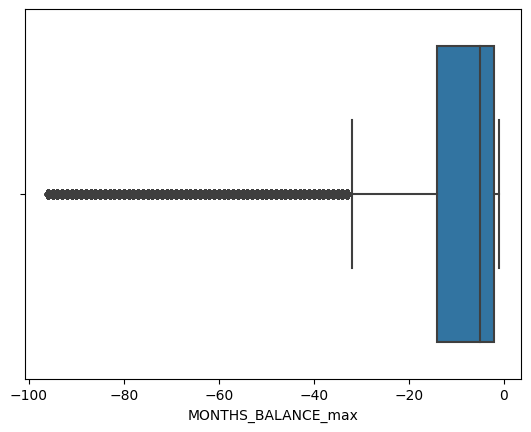

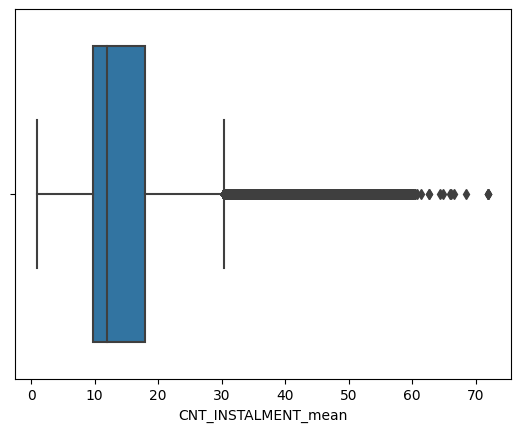

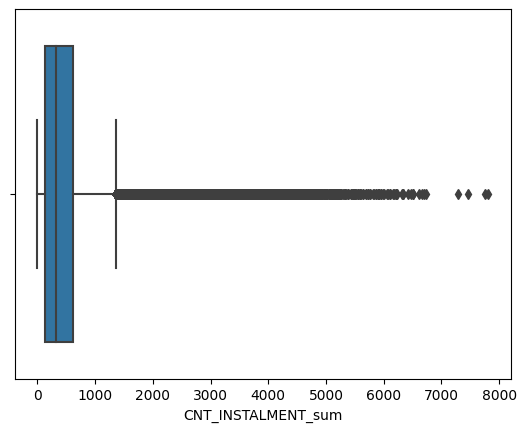

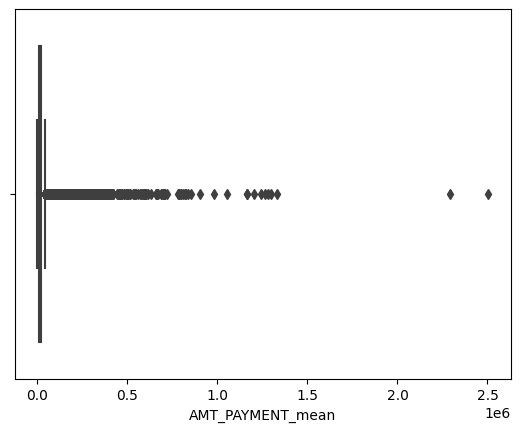

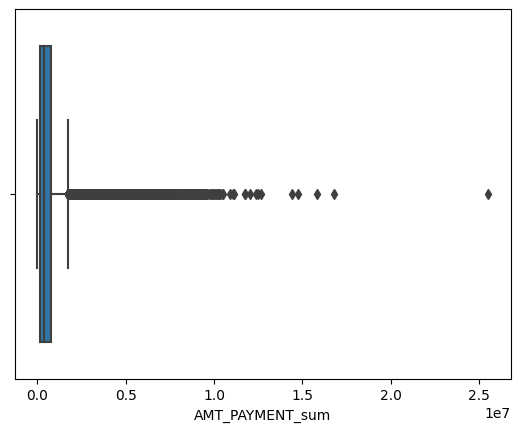

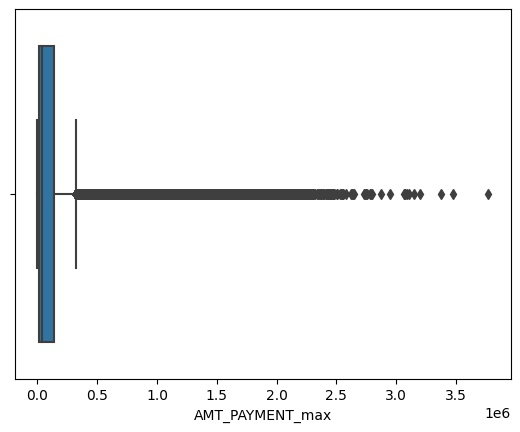

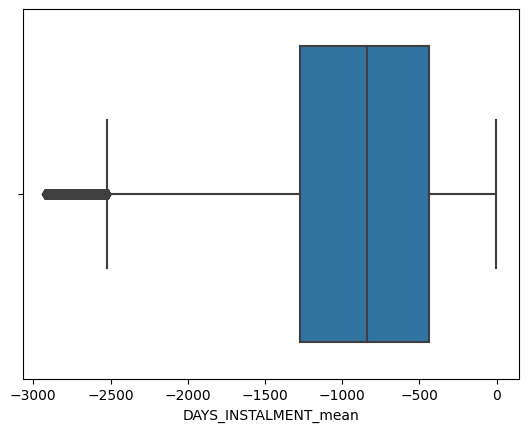

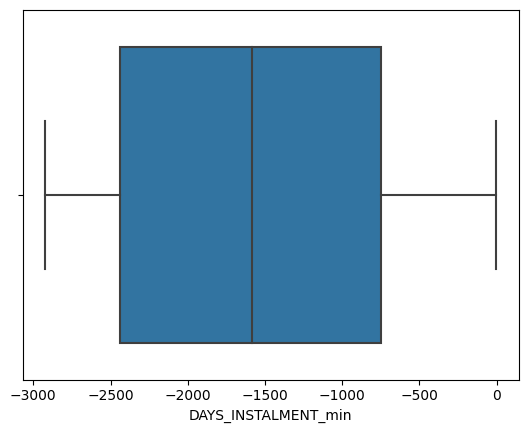

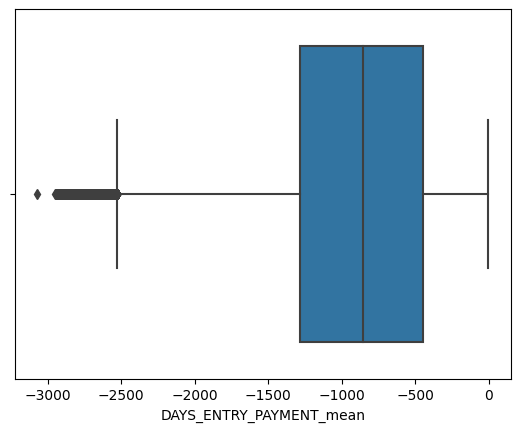

In [158]:
# Boxplot to check Outliers
for col in numerical_cols:
    sns.boxplot(x=app_train[col])
    plt.show()

In [159]:
# for removing outliers

for col in numerical_cols:
    # Calculating the 1st percentile
    q1 = app_train[col].quantile(0.01)
    # Calculating the 1st percentile
    q99 = app_train[col].quantile(0.99)
    # cliping the values above q99 and below q1 
    app_train[col] = app_train[col].clip(lower=q1, upper=q99)

# shape of app_train after removing outliers(it will remain same because we are replacing it)
app_train.shape

(307511, 98)

In [160]:
# dummies for categorical columns in app_train
app_train = pd.get_dummies(app_train, columns=categorical_cols, drop_first=True)

In [161]:
#shap of app_train
app_train.shape

(307511, 198)

In [162]:
#dropping dublicates
app_train = app_train.drop_duplicates()
app_train.shape

(307511, 198)

In [163]:
# counting target variables
app_train["TARGET"].value_counts()

TARGET
0.0    282686
1.0     24825
Name: count, dtype: int64

# **Logistics Regression**

In [164]:
#seperating variables from features and target
X_LR = app_train.drop(columns=["TARGET"])  # Features
y_LR = app_train["TARGET"]  # Target variable


In [166]:
lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
lasso.fit(X_LR, y_LR)

# Identifying the selected features
selected_features_LR = X_LR.columns[lasso.coef_[0] != 0]

#printing selected features
print("Selected Features:", selected_features_LR)


Selected Features: Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'ORGANIZATION_TYPE_Trade: type 4', 'ORGANIZATION_TYPE_Trade: type 6',
       'ORGANIZATION_TYPE_Trade: type 7',
       'ORGANIZATION_TYPE_Transport: type 1',
       'ORGANIZATION_TYPE_Transport: type 2',
       'ORGANIZATION_TYPE_Transport: type 3',
       'ORGANIZATION_TYPE_Transport: type 4', 'ORGANIZATION_TYPE_University',
       'ORGANIZATION_TYPE_XNA', 'EMERGENCYSTATE_MODE_Yes'],
      dtype='object', length=167)


In [167]:
#number of selected_features_LR
selected_features_LR.shape

(167,)

In [168]:
#selcted features in X_LR
X_LR = X_LR[selected_features_LR]

In [169]:
#splitting the dataset
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(X_LR, y_LR, test_size=0.3, stratify=y_LR, random_state=42)

# Standardizing the X_train_LR, X_test_LR
scaler = StandardScaler()
X_train_LR = scaler.fit_transform(X_train_LR)
X_test_LR = scaler.transform(X_test_LR)

In [170]:
#using SMOTE to handle imbalanced target variables
smote = SMOTE(random_state=42)
X_train_LR, y_train_LR = smote.fit_resample(X_train_LR, y_train_LR)

#printing distribution of Target Variables after SMOTE
print("Class distribution after SMOTE:")
print(y_train_LR.value_counts())

Class distribution after SMOTE:
TARGET
0.0    197880
1.0    197880
Name: count, dtype: int64


In [171]:
# Initializing a Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)

In [172]:
#training Logistics Regression Model
lr_model.fit(X_train_LR, y_train_LR) 

LogisticRegression(max_iter=1000, random_state=42)

In [173]:
#prediction for test data
y_pred_LR = lr_model.predict(X_test_LR)

# Probability for ROC-AUC
y_pred_proba_LR = lr_model.predict_proba(X_test_LR)[:, 1]  

In [174]:
# printing the classification report 
print(classification_report(y_test_LR, y_pred_LR))

#printing the ROC-AUC
print("ROC-AUC Score:", roc_auc_score(y_test_LR, y_pred_proba_LR))


              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     84806
         1.0       0.16      0.66      0.26      7448

    accuracy                           0.70     92254
   macro avg       0.56      0.68      0.54     92254
weighted avg       0.90      0.70      0.77     92254

ROC-AUC Score: 0.7456134624997275


# **Decision Tree**

In [175]:
#seperating variables from features and target
X_DT = app_train.drop(columns=["TARGET"])  # Features
y_DT = app_train["TARGET"]  # Target variable

In [176]:
model_DT = DecisionTreeClassifier(random_state=42)
model_DT.fit(X_DT, y_DT)

DecisionTreeClassifier(random_state=42)

In [177]:
importance_DT = pd.DataFrame({
    'Feature': X_DT.columns,
    'Importance': model_DT.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Displying top features
print(importance_DT.head(20))

                       Feature  Importance
27                EXT_SOURCE_2    0.058379
28                EXT_SOURCE_3    0.049991
0                   SK_ID_CURR    0.032204
9            DAYS_REGISTRATION    0.031478
10             DAYS_ID_PUBLISH    0.030941
7                   DAYS_BIRTH    0.030866
4                  AMT_ANNUITY    0.028274
80             AMT_PAYMENT_max    0.027789
78            AMT_PAYMENT_mean    0.026904
76         CNT_INSTALMENT_mean    0.025628
40      DAYS_LAST_PHONE_CHANGE    0.024029
6   REGION_POPULATION_RELATIVE    0.023446
8                DAYS_EMPLOYED    0.023245
79             AMT_PAYMENT_sum    0.023037
71              AMT_CREDIT_sum    0.022752
77          CNT_INSTALMENT_sum    0.022020
2             AMT_INCOME_TOTAL    0.021216
67        AMT_APPLICATION_mean    0.019441
3                   AMT_CREDIT    0.019292
20     HOUR_APPR_PROCESS_START    0.018091


In [178]:
top_features_DT = importance_DT['Feature'].head(60).tolist()
X_DT = X_DT[top_features_DT]

In [179]:
#splitting the Dataset
X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(X_DT, y_DT, test_size=0.3, stratify=y_DT, random_state=42)

# Standardizing the X_train_DT, X_test_DT
scaler = StandardScaler()
X_train_DT = scaler.fit_transform(X_train_DT)
X_test_DT = scaler.transform(X_test_DT)

In [180]:
#using SMOTE to balance the target variables
smote = SMOTE(random_state=42)
X_train_DT, y_train_DT = smote.fit_resample(X_train_DT, y_train_DT)


print("Class distribution after SMOTE:")
print(y_train_DT.value_counts())

Class distribution after SMOTE:
TARGET
0.0    197880
1.0    197880
Name: count, dtype: int64


In [181]:
# Initializing the Decision Tree Classifier
model_DT = DecisionTreeClassifier(random_state=42, max_depth=5)

# Fitting the model on the training data
model_DT.fit(X_train_DT, y_train_DT)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [182]:
# Prediction on the test data
y_pred_DT = model_DT.predict(X_test_DT)

# Probability for ROC-AUC
y_pred_proba_DT = model_DT.predict_proba(X_test_DT)[:, 1] 

# printiing the Classification Report
print("Classification Report:\n", classification_report(y_test_DT, y_pred_DT))

# printing ROC-AUC Score
print("ROC-AUC Score:", roc_auc_score(y_test_DT, y_pred_proba_DT))


Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.78      0.85     84806
         1.0       0.14      0.42      0.21      7448

    accuracy                           0.75     92254
   macro avg       0.54      0.60      0.53     92254
weighted avg       0.87      0.75      0.80     92254

ROC-AUC Score: 0.6552390199070133


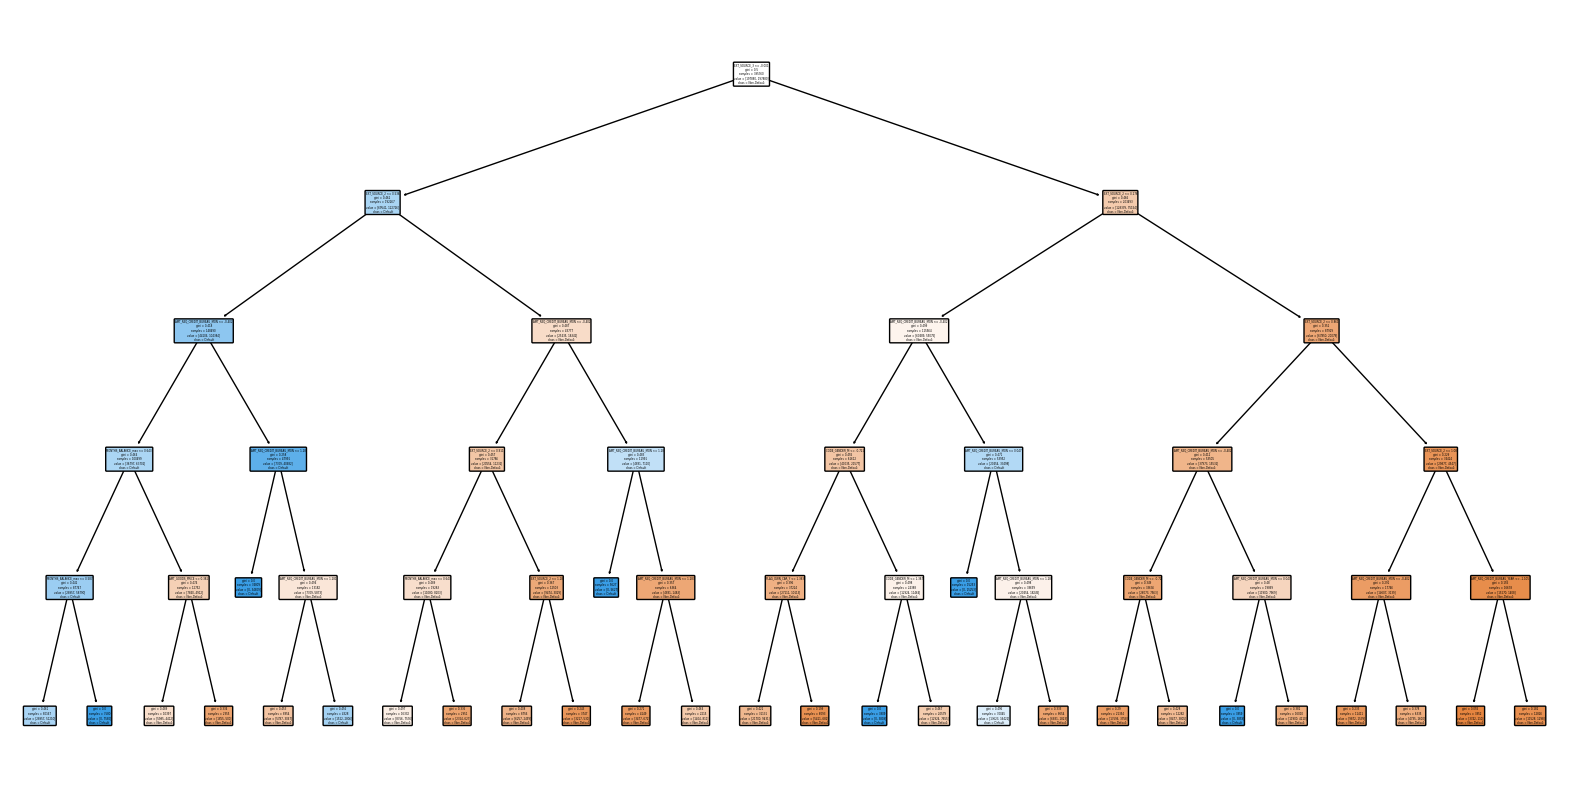

In [183]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(model_DT, feature_names=X_DT.columns, class_names=['Non-Default', 'Default'], filled=True, rounded=True)
plt.show()

# **Random Tree Forest**

In [204]:
#seperating variables from features and target
X_RF = app_train.drop(columns=["TARGET"])  # Features
y_RF = app_train["TARGET"]  # Target variable

In [205]:
model_RF = RandomForestClassifier(n_estimators=50, random_state=42)
model_RF.fit(X_RF, y_RF)

RandomForestClassifier(n_estimators=50, random_state=42)

In [206]:
importance_RF = pd.DataFrame({
    'Feature': X_RF.columns,
    'Importance': model_RF.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top features
print(importance_RF.head(20))

                    Feature  Importance
27             EXT_SOURCE_2    0.042299
28             EXT_SOURCE_3    0.040013
7                DAYS_BIRTH    0.026871
10          DAYS_ID_PUBLISH    0.025433
9         DAYS_REGISTRATION    0.024705
78         AMT_PAYMENT_mean    0.024327
80          AMT_PAYMENT_max    0.023870
0                SK_ID_CURR    0.023591
4               AMT_ANNUITY    0.022967
8             DAYS_EMPLOYED    0.022633
83  DAYS_ENTRY_PAYMENT_mean    0.022618
79          AMT_PAYMENT_sum    0.022600
71           AMT_CREDIT_sum    0.022497
67     AMT_APPLICATION_mean    0.022330
81     DAYS_INSTALMENT_mean    0.022191
76      CNT_INSTALMENT_mean    0.022024
82      DAYS_INSTALMENT_min    0.021886
3                AMT_CREDIT    0.021768
70          AMT_CREDIT_mean    0.021667
40   DAYS_LAST_PHONE_CHANGE    0.021650


In [207]:
top_features_RF = importance_RF['Feature'].head(30).tolist()
X_RF = X_RF[top_features_RF]

In [208]:
#counting the target vaiables
y_RF.value_counts()

TARGET
0.0    282686
1.0     24825
Name: count, dtype: int64

In [209]:
#splitting the dataset
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X_RF, y_RF, test_size=0.3, stratify=y_RF, random_state=42)

In [210]:
# counting the target variable in training set
y_train_RF.value_counts()

TARGET
0.0    197880
1.0     17377
Name: count, dtype: int64

In [211]:
#using smote to handle the imbalanced target variables
smote = SMOTE(random_state=42)
X_train_RF, y_train_RF = smote.fit_resample(X_train_RF, y_train_RF)

print("Class distribution after SMOTE:")
print(y_train_RF.value_counts())

Class distribution after SMOTE:
TARGET
0.0    197880
1.0    197880
Name: count, dtype: int64


In [212]:
#initilizing the Rando forest model
model_RF = RandomForestClassifier( random_state=42, n_estimators=100)


In [213]:
#training the model
model_RF.fit(X_train_RF, y_train_RF)

RandomForestClassifier(random_state=42)

In [214]:
# Prediction on the test data
y_pred_RF = model_RF.predict(X_test_RF)

# Probabilities for ROC-AUC
y_pred_proba_RF = model_RF.predict_proba(X_test_RF)[:, 1]  


In [215]:
print(classification_report(y_test_RF, y_pred_RF))
print("ROC-AUC Score:", roc_auc_score(y_test_RF, y_pred_proba_RF))


              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94     84806
         1.0       0.18      0.13      0.15      7448

    accuracy                           0.88     92254
   macro avg       0.55      0.54      0.54     92254
weighted avg       0.87      0.88      0.87     92254

ROC-AUC Score: 0.6811799062055907


# **XGBoost**

In [223]:
#seperating variables from features and target
X_XGB = app_train.drop(columns=["TARGET"])  # Features
y_XGB = app_train["TARGET"]  # Target variable

In [224]:
#feature selection

model_XGB = XGBClassifier()
model_XGB.fit(X_XGB, y_XGB)
importance_XGB = model_XGB.feature_importances_

# Rank features by importance
top_features_XGB = pd.DataFrame({'Feature': X_XGB.columns, 'Importance': importance_XGB}).sort_values(by='Importance', ascending=False)
print(top_features_XGB.head(100))

                                  Feature  Importance
28                           EXT_SOURCE_3    0.039768
27                           EXT_SOURCE_2    0.036806
62              AMT_REQ_CREDIT_BUREAU_DAY    0.024092
102  NAME_EDUCATION_TYPE_Higher education    0.022323
101              NAME_INCOME_TYPE_Working    0.019930
..                                    ...         ...
107          NAME_FAMILY_STATUS_Separated    0.004800
36               OBS_30_CNT_SOCIAL_CIRCLE    0.004789
66             AMT_REQ_CREDIT_BUREAU_YEAR    0.004788
117         OCCUPATION_TYPE_Cooking staff    0.004785
158    ORGANIZATION_TYPE_Industry: type 3    0.004773

[100 rows x 2 columns]


In [225]:
#top 40
top_features_XGB = top_features_XGB['Feature'].head(40).tolist()

# Filter the dataset to include only the top features
X_XGB = X_XGB[top_features_XGB]

In [226]:
#splitting the data
X_train_XGB, X_test_XGB, y_train_XGB, y_test_XGB = train_test_split(X_XGB, y_XGB, test_size=0.3, stratify=y_XGB, random_state=42)

In [227]:
#using the SMOTE to handle the imbalanced target variable 
smote = SMOTE(random_state=42)
X_train_XGB, y_train_XGB = smote.fit_resample(X_train_XGB, y_train_XGB)

print("Class distribution after SMOTE:")
print(y_train_XGB.value_counts())

Class distribution after SMOTE:
TARGET
0.0    197880
1.0    197880
Name: count, dtype: int64


In [228]:
# Initializing XGBoost
model_XGB = XGBClassifier(random_state=42, n_estimators=100)

# Training the model
model_XGB.fit(X_train_XGB, y_train_XGB)

# Making predictions on the test data
y_pred_XGB = model_XGB.predict(X_test_XGB)
y_pred_proba_XGB = model_XGB.predict_proba(X_test_XGB)[:, 1]

# Printing the Classification Report 
print("XGBoost Classification Report:")
print(classification_report(y_test_XGB, y_pred_XGB))

#printing the ROC-AUC Score
print("XGBoost ROC-AUC Score:", roc_auc_score(y_test_XGB, y_pred_proba_XGB))


XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     84806
         1.0       0.39      0.07      0.12      7448

    accuracy                           0.92     92254
   macro avg       0.66      0.53      0.54     92254
weighted avg       0.88      0.92      0.89     92254

XGBoost ROC-AUC Score: 0.7280748009996556


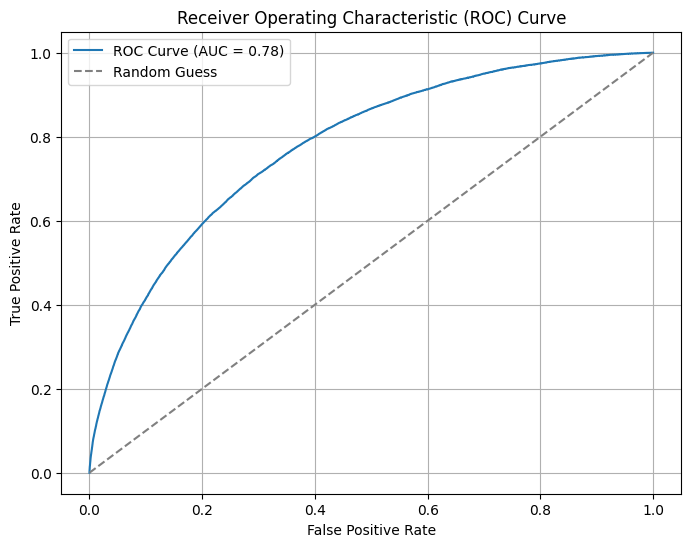

In [229]:
# Get false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_XGB, model_XGB.predict_proba(X_XGB)[:, 1])

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid()
plt.show()